In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
df = pd.read_csv('../data/Diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print(f"Shape of the data: {df.shape}")

Shape of the data: (768, 9)


## 1.2 EDA

In [4]:
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

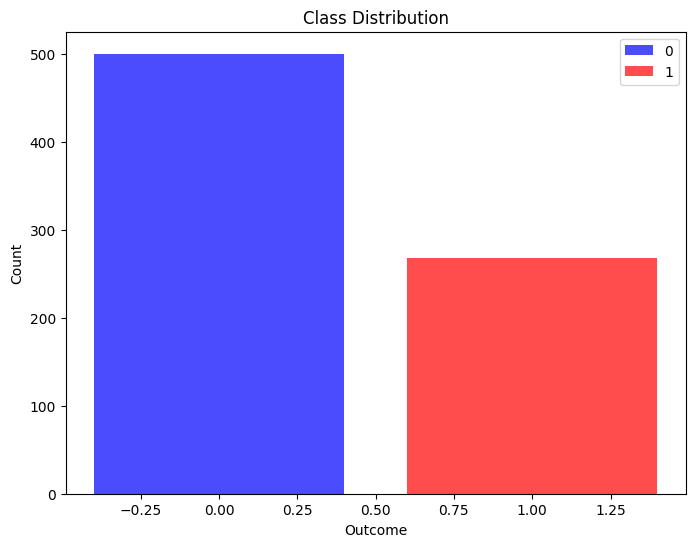

In [12]:
outcome_counts = df['Outcome'].value_counts()
labels = outcome_counts.index
counts = outcome_counts.values
colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
bars = [plt.bar(x, count, color=color, alpha=0.7) for x, count, color in zip(labels, counts, colors)]

plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Outcome')

plt.legend(bars, labels)



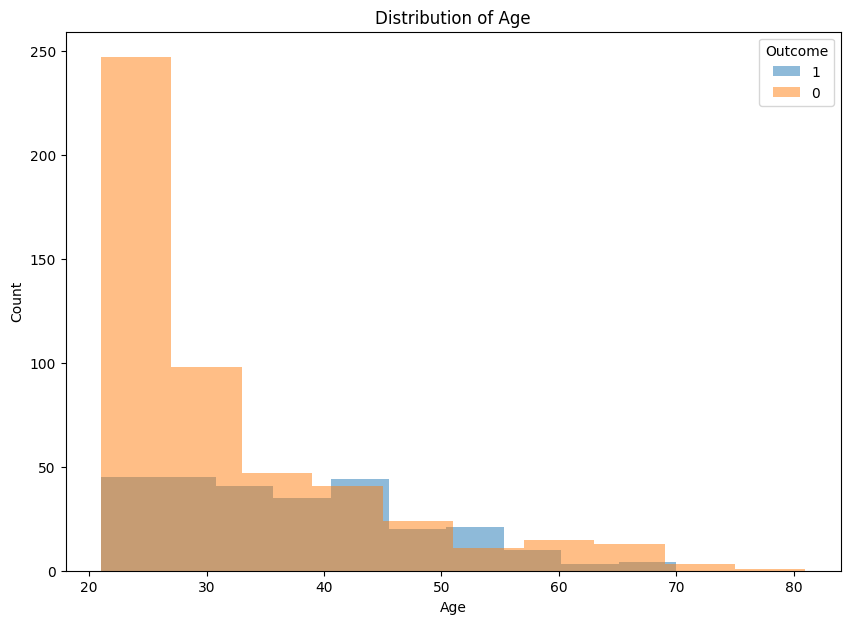

In [13]:
plt.figure(figsize=(10, 7))

for outcome in df['Outcome'].unique():
    plt.hist(df[df['Outcome'] == outcome]['Age'], alpha=0.5, label=str(outcome))

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.legend(title='Outcome')
plt.show()

# 2. Data Preproccesing

## 2.1 Correlation Analysis 

<Axes: >

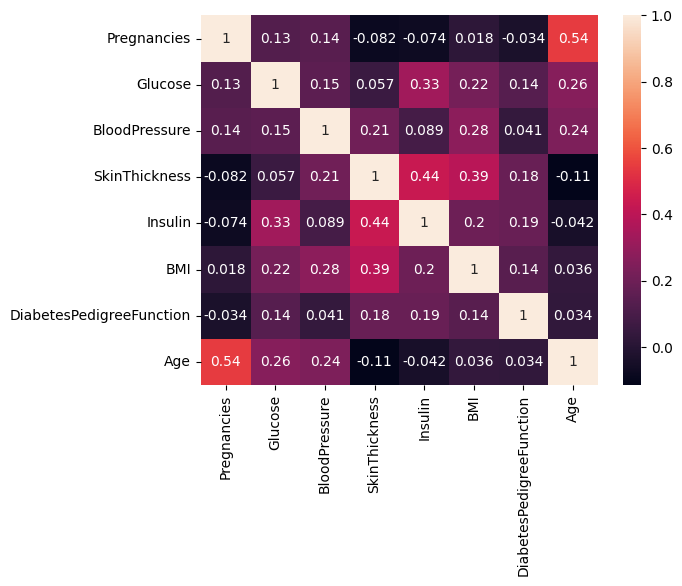

In [14]:
df_features = df.drop(columns='Outcome')
sns.heatmap(df_features.corr(), annot=True)

In [15]:
df_num = df.select_dtypes(include=[np.number])

In [16]:
X_scaler = StandardScaler()

X = df.drop(columns='Outcome')
y = df['Outcome']

X_scaled = X_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4]
}

xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, 
                                   n_iter=50, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=1, random_state=42)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_

best_model = random_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
                                  


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best score: 0.815544019933555


In [17]:
feature_importance = random_search.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(feature_importance, index=X.columns, columns=['importance'])
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance


,importance
Glucose,0.276176
BMI,0.138711
Age,0.121024
Insulin,0.101895
Pregnancies,0.101609
DiabetesPedigreeFunction,0.097991
SkinThickness,0.081301
BloodPressure,0.081294


<Axes: >

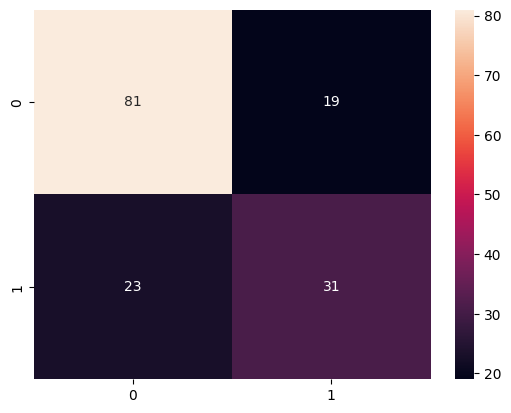

In [18]:
y_pred = best_model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True)



In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       100
           1       0.62      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.70       154
weighted avg       0.72      0.73      0.72       154

